In [1]:
import corner

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import celerite2
from celerite2 import terms

from scipy.optimize import minimize,curve_fit

import os
CWD = "/".join(os.getcwd().split("/")[:-2])
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")

from funcs.helper import read_custom_aperture_lc, fetch_lightcurve
from funcs.multiperiod import show_flare, find_period

import time
# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())


import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}



def cosine(x, a, b, c, d, e):
    """cosine with a linear trend"""
    return a * np.cos(b * x + c) + d * x + e

In [11]:
# select a target
target = lcs.iloc[-6]
target

ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
GRP                                NaN
plxmas                             NaN
eplxmas                            NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                

In [14]:
inits = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")
inits_ = inits[str(target.ID) == inits.ID.str.strip("ab")]#.str.strip("ab")
inits_

,tstamp,ID,phi_a,theta_a,a,fwhm1,fwhm2,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median,log_prob,nparam
6,30_10_2020_14_04,237880881a,2.0,1.139629,1.902554,0.15,0.2,9.061636e+10,6.0,0.371856,0.040246,23.717739,0.275151,8.870689e+30,615.294854,log_probability_2flares,11
7,06_11_2020_07_58,237880881a,2.0,1.139629,1.902554,0.15,0.2,9.061636e+10,6.0,0.371856,0.040246,23.717739,0.275151,8.870689e+30,615.294854,log_probability_2flares,11
8,30_10_2020_14_04,237880881b,4.9,1.139629,0.525537,1.10,1.4,9.061636e+10,6.0,0.371856,0.040246,23.717739,0.275151,8.870689e+30,615.294854,log_probability_2flares,11
9,06_11_2020_07_58,237880881b,4.9,1.139629,0.525537,1.10,1.4,9.061636e+10,6.0,0.371856,0.040246,23.717739,0.275151,8.870689e+30,615.294854,log_probability_2flares,11


In [15]:
row = inits_.iloc[0]
ID =row.ID.strip("ab")
lc = pd.read_csv(f"{CWD}/data/lcs/{row.tstamp}_{ID}.csv")
target.view_start, target.view_stop = lc.t.iloc[0], lc.t.iloc[-1]
assert target.view_start == lc.t.iloc[0]
assert target.view_stop == lc.t.iloc[-1]

In [16]:
target.view_start, target.view_stop

(1331.5510676256595, 1332.9497072671284)

In [48]:
# get TESS LC here
flc = fetch_lightcurve(target)

# select subset of to run GP regression on
gpstart, gpstop = target.view_start-1.7, target.view_stop+2.
select = np.where((flc.time > gpstart) & (flc.time < gpstop))
flc = flc[select]

# remove non-finite values
print(flc.flux.shape)
flc = flc[np.where(np.isfinite(flc.flux))]
flc.flux.shape

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


(3530,)


(3530,)

In [49]:
true_t = flc.time
true_y = flc.flux
true_yerr = flc.flux_err

In [50]:
# mask flare here

# 237
# 1333, 1331.5
mask = np.where((flc.time > target.view_stop-.1) | (flc.time < target.view_start-.25))
flcm = flc[mask]


In [57]:
flcm = flcm[flcm.flux < np.median(flcm.flux) + np.std(flcm.flux)*3]

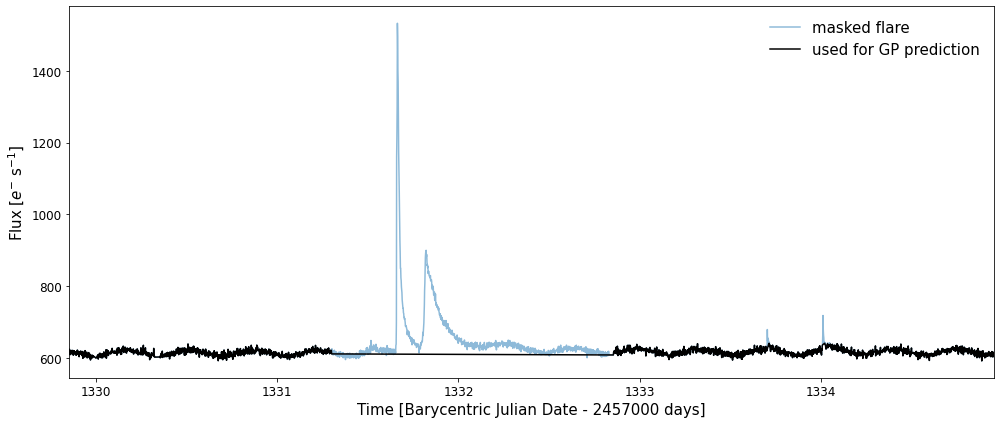

In [58]:
plt.figure(figsize=(14,6))
plt.plot(true_t, true_y, alpha=.5, label="masked flare")
plt.plot(flcm.time, flcm.flux,c="k", label="used for GP prediction")
plt.xlim(gpstart,gpstop)
plt.xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=15)
plt.ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=15)
plt.legend(frameon=False, loc=1, fontsize=15)
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/results/rotation/{tstamp}_TIC{target.ID}_GP_lc.png", dpi=300)

In [59]:
flcm.flux.shape

(2469,)

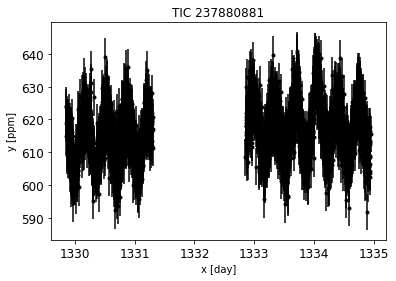

In [60]:
t = flcm.time
y = flcm.flux
yerr = flcm.flux_err


# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
_ = plt.title(f"TIC {target.ID}")

In [61]:
# add rotation period as determined from all available light curves
props = pd.read_csv(f"{CWD}/data/summary/inclination_input.csv")

P = props[props["id"] == int(ID)].iloc[0].prot_d
P

0.351489271751592

In [62]:
flcm.flux.shape

(2469,)

In [63]:
# Quasi-periodic term
# 237 = [5.5,P,100.,5.5,100,.5]
# 449
inits = [11., P, 150., .4, .9, 2.3, 35., 10.]

# Quasi-periodic term
term1 = terms.RotationTerm(sigma=inits[0], period=P, Q0=inits[2], dQ=inits[3], f=inits[4])


# Quasi-periodic term
term2 = terms.SHOTerm(sigma=inits[5], rho=inits[6], tau=inits[7])

# define kernel
kernel = term1 + term2


# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=np.nanmedian(flcm.flux))
gp.compute(t, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -7761.588571268691


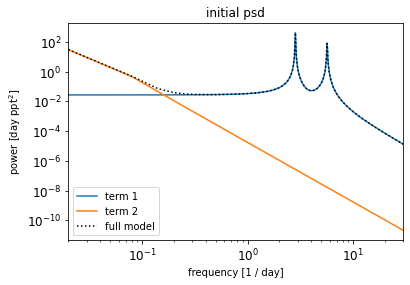

In [64]:
freq = np.linspace(0.02, 30, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label="term {0}".format(n + 1))
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)

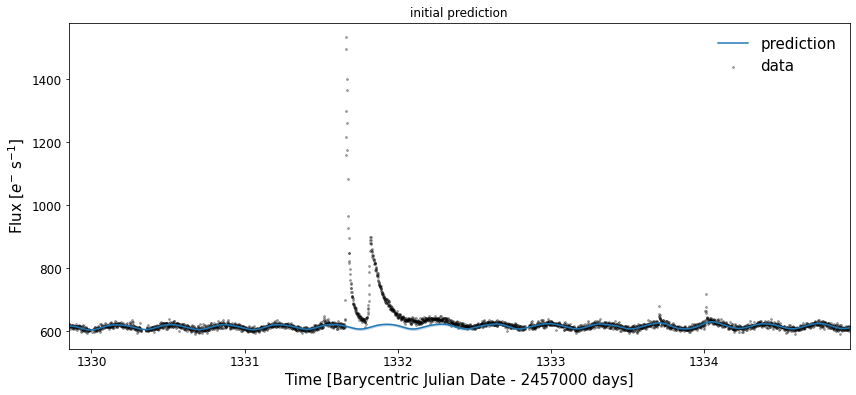

In [65]:

def plot_prediction(gp):
    plt.scatter(true_t, true_y, c="k", s=3.5, alpha=0.3, label="data")
#     plt.errorbar(t[::30], y[::30], yerr=yerr[::30], fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=true_t, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_t, mu, label="prediction")
       
        plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("t [day]")
    plt.ylabel("flux [ppm]")
    plt.xlim(target.view_start, target.view_stop)
#     plt.ylim(1600,1800)
    plt.legend()


plt.figure(figsize=(14,6))
plt.title("initial prediction")
plot_prediction(gp)

plt.xlim(gpstart,gpstop)
plt.xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=15)
plt.ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=15)
plt.legend(frameon=False, loc=1, fontsize=15)
plt.savefig(f"{CWD}/analysis/results/rotation/{tstamp}_TIC{target.ID}_GP_init_prediction.png", dpi=300)

In [66]:


def set_params(params, gp):
    gp.mean = params[0]
    inits = np.exp(params[1:])
    gp.kernel = (terms.RotationTerm(sigma=inits[0], period=inits[1], Q0=inits[2], dQ=inits[3], f=inits[4]) +
                 terms.SHOTerm(sigma=inits[5], rho=inits[6], tau=inits[7]))
    gp.compute(t, diag=yerr ** 2, quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(y)


initial_params =  [np.nanmedian(flcm.flux)] + inits
initial_params = [np.log(x) for x in initial_params]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

      fun: 7735.998644403344
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.00044417e-03,  5.60612534e-01,  1.01504156e+01, -8.14907253e-02,
        6.54836185e-03,  2.81579560e-01,  4.39194991e-01,  7.29414751e-01,
       -1.79079507e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1280
      nit: 77
   status: 0
  success: True
        x: array([ 6.44411428,  1.68160671, -1.04338383,  8.35178786, -0.18775057,
       -6.15447957,  6.71239655,  3.960081  , -6.13996723])

In [105]:
np.exp(-1.043)

0.35239590686961875

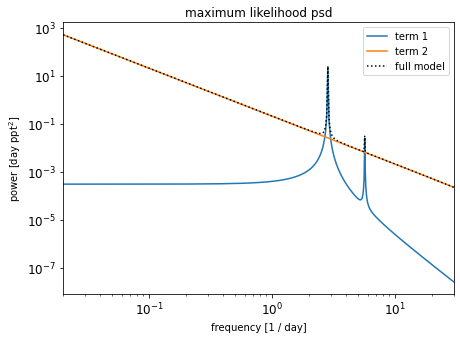

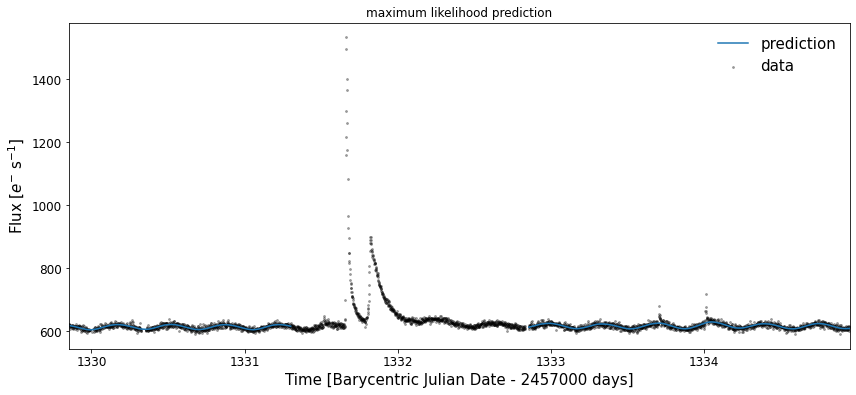

In [67]:
plt.figure(figsize=(7,5))
plt.title("maximum likelihood psd")
plot_psd(opt_gp)

#-----------

plt.figure(figsize=(14,6))
plt.title("maximum likelihood prediction")
plot_prediction(gp)

plt.xlim(gpstart,gpstop)
# plt.xlim(target.view_start, target.view_stop)
plt.xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=15)
plt.ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=15)
plt.legend(frameon=False, loc=1, fontsize=15)
plt.savefig(f"{CWD}/analysis/results/rotation/{tstamp}_TIC{target.ID}_GP_ML_prediction.png", dpi=300)

In [ ]:
import emcee

prior_sigma = 2.0


def log_prob(params, gp):
    gp = set_params(params, gp)
    return (
        gp.log_likelihood(y) - 0.5 * np.sum((params / prior_sigma) ** 2),
        gp.kernel.get_psd(omega),
    )


initslog = soln.x
coords = initslog + 1e-5 * np.random.randn(32, len(initslog))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob, args=(gp,)
)
state = sampler.run_mcmc(coords, 200, progress=True)

In [99]:

state = sampler.run_mcmc(state, 1500, progress=True)

100%|██████████| 1500/1500 [00:47<00:00, 31.39it/s]


In [100]:


#-------

# # Fetch light curve
# flck = fetch_lightcurve(target)

# # Get the dominant modulation period
# period, mfp = find_period(target, save=False, plot=False)

# # Optimize for the model parameters using
# # non-linear least-squares (Levenberg-Marquardt):
# cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
# p, p_cov = curve_fit(cosine, flck.time[cond],
#                               flck.flux[cond],
#                               p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
#                                   0, 0, np.nanmean(flck.flux)],
#                               method="lm")
# model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

# # Calculate the relative amplitude of the oscillation
# rel_amplitude = p[0] / np.nanmedian(flck.flux)
# print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")


# plt.plot(flck.time, model,linewidth=3,
#              c="orange",label=f"{period:.2f} rotation period")   

# # ---

chain = sampler.get_chain(discard=1500, flat=True)
print(chain.shape[0]/32)

3000.0


[-0.64705343  1.52124082 -1.03646454  4.00471633  3.15990284 -6.3728716
  6.15430047  5.26844827 -3.17711767]


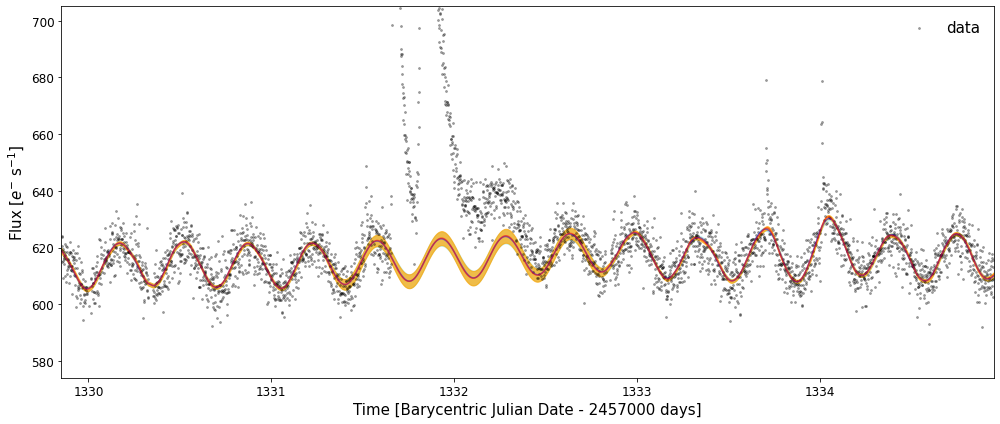

In [133]:
plt.figure(figsize=(14,6))

for sample in chain[np.random.randint(len(chain), size=1)]:
    print(sample)
    gp = set_params(sample, gp)
    mu, variance = gp.predict(y, t=true_t, return_var=True)
    sigma = np.sqrt(variance)
    plt.plot(true_t, mu, c="b", alpha=.5)
    plt.fill_between(true_t, mu - sigma, mu + sigma, color="c", alpha=0.2)

    
mcmc_res = [np.percentile(chain[:, i], [50]) for i in range(9)]
gp = set_params(mcmc_res, gp)
mu, variance = gp.predict(y, t=true_t, return_var=True)
plt.plot(true_t, mu, c="r", alpha=.5)
plt.fill_between(true_t, mu - sigma, mu + sigma, color="orange", alpha=0.7)
    
plot_prediction(None)
plt.xlim(gpstart,gpstop)
plt.ylim(np.min(flcm.flux)*.97, np.max(flcm.flux)*1.1)
plt.xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=15)
plt.ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=15)
plt.legend(frameon=False, loc=1, fontsize=15)
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/results/rotation/{tstamp}_TIC{target.ID}_GP_MCMC_prediction.png", dpi=300)

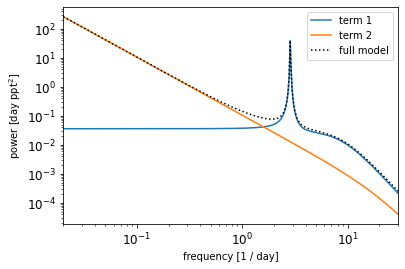

In [108]:
plot_psd(gp)

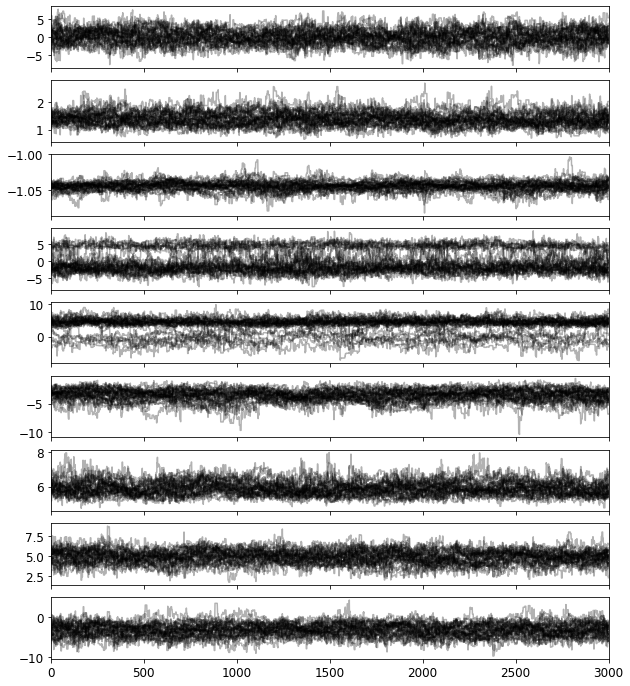

In [109]:
# labels = [r'$t_\mathrm{f} [d]$', r'$\theta_\mathrm{f}$ [deg]', 
#           'a', 'FWHM [d]', r'$i$ [deg]',
#           r"$\phi_\mathrm{f}$ [deg]"]
# matplotlib.rc('xtick', labelsize=12) 
# matplotlib.rc('ytick', labelsize=12) 
fig, axes = plt.subplots(9, figsize=(10, 12), sharex=True)
msamples = sampler.get_chain(discard=1500)

for j in range(9):
    ax = axes[j]
    ax.plot(msamples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(msamples))
#     ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [141]:
np.exp(np.percentile(chain[:, 2], [16,50,84]))

array([0.34995645, 0.35199846, 0.35387017])

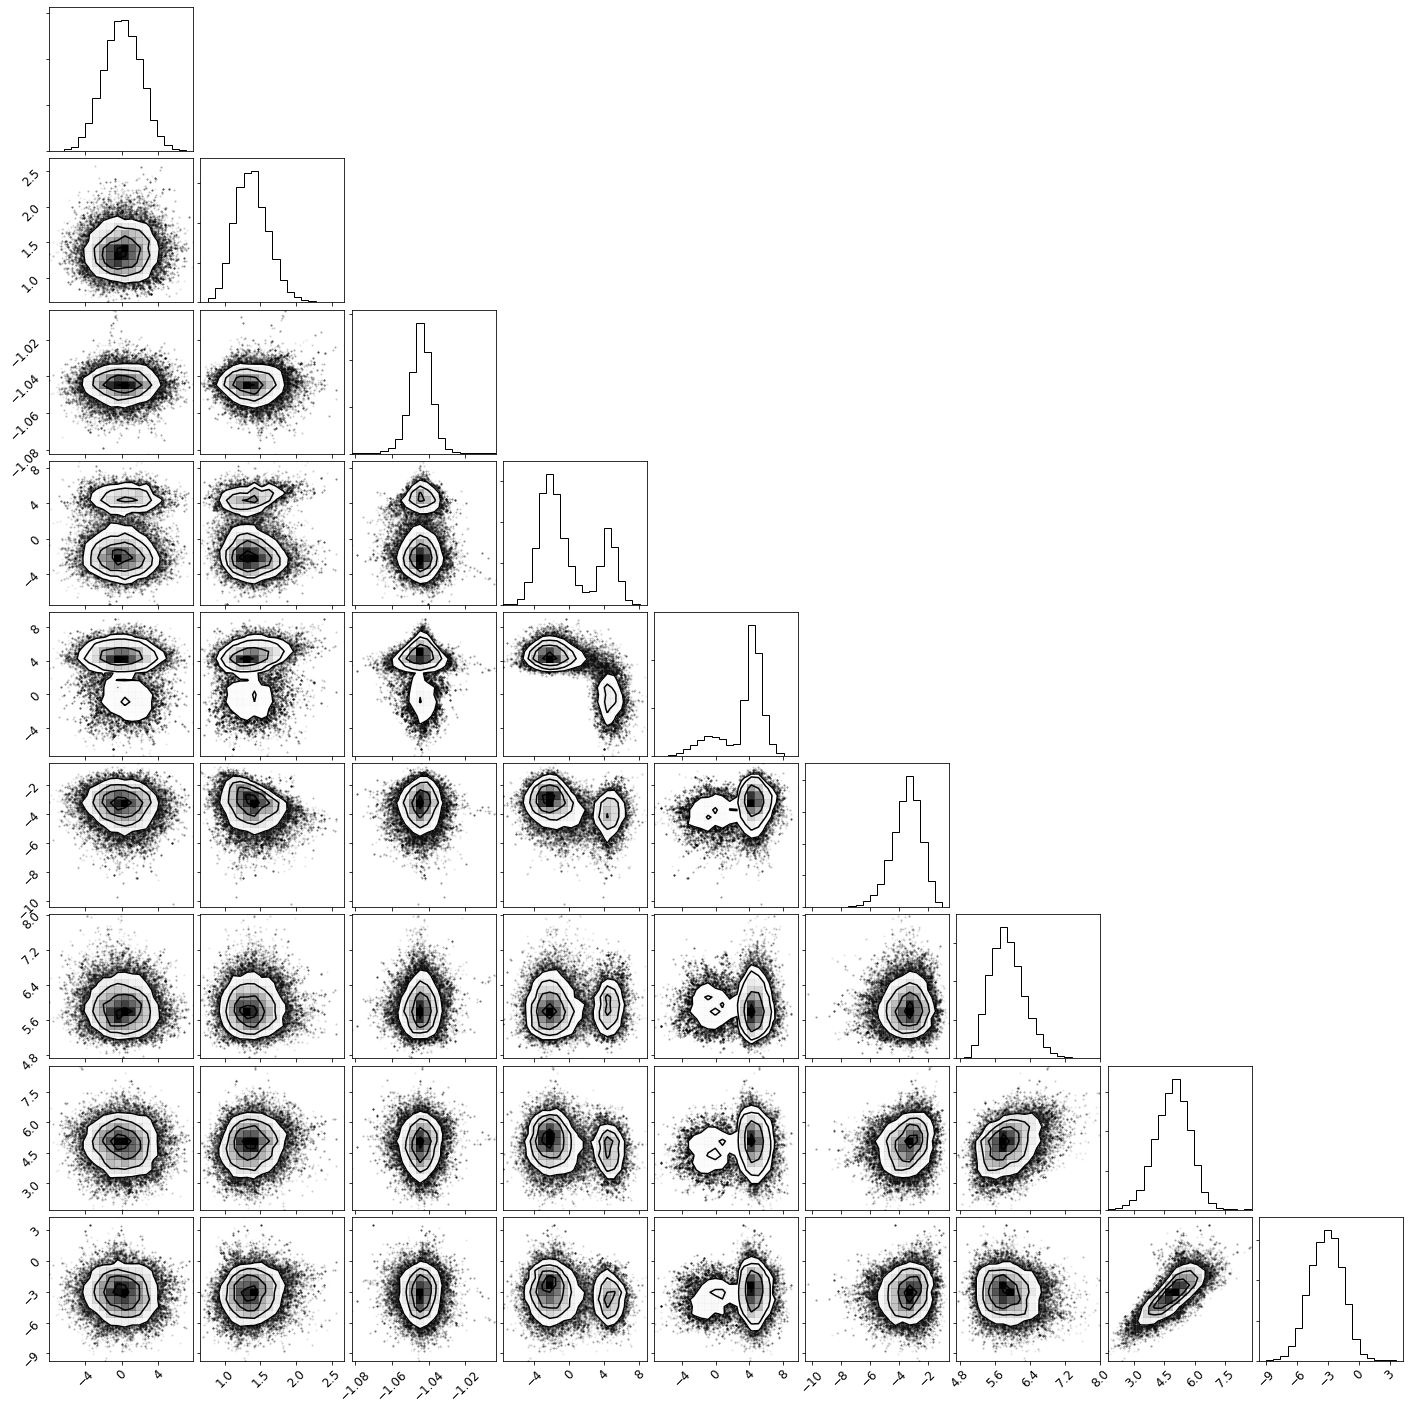

In [104]:
corner.corner(chain);

# Save inits and LC

In [110]:
# new median
# new tstamp
# mask = np.where((flc.time > target.view_stop-.3) | (flc.time < target.view_start-.15))
selectformcmc = (true_t > target.view_start) & (true_t <= target.view_stop)
#----------------
# 277 extra mask
# selectformcmc[1100:1100+1173-891] = 0
#--------------
modelflux = mu[selectformcmc]
modelflux_err = sigma[selectformcmc]
fullflux = true_y[selectformcmc]
fullyerr = true_yerr[selectformcmc]
time = true_t[selectformcmc]


#save inits with new median and timestamp
# 277 extra mask


# save lc with new timestamp

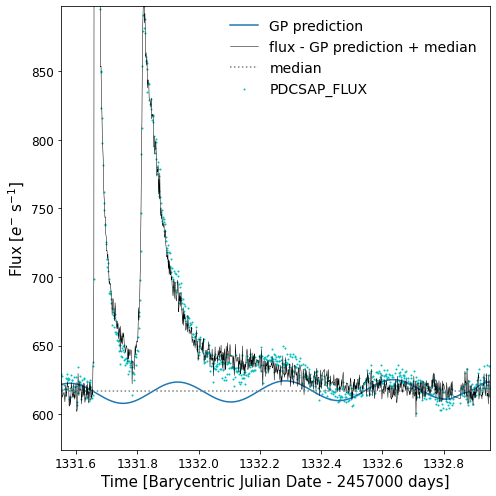

In [112]:
plt.figure(figsize=(7,7))
plt.scatter(time, fullflux, s=1, c="c", label="PDCSAP_FLUX")
plt.plot(time, modelflux, label="GP prediction")
plt.plot(time, fullflux-modelflux + np.nanmedian(modelflux), c="k", linewidth=.5,
         label="flux - GP prediction + median")
plt.plot(time, [np.nanmedian(modelflux)] * len(time), linestyle="dotted", c="grey", label="median")
plt.xlim(target.view_start,target.view_stop)
#plt.xlim(gpstart,gpstop)
plt.ylim(np.min(flcm.flux)*.97, np.max(flcm.flux)*1.4)
plt.xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=15)
plt.ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=15)
plt.legend(frameon=False, loc=1, fontsize=14)
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/results/rotation/{tstamp}_TIC{target.ID}_GP_MCMC_new_lc.png", dpi=300)

In [113]:
new_flux_err = np.sqrt(fullyerr**2 + modelflux_err**2)
new_t = time
new_phi = (new_t - new_t[0]) / P * 2 * np.pi
new_median = np.nanmedian(modelflux)
new_flux = fullflux-modelflux + np.nanmedian(modelflux)


In [123]:
newlc = pd.DataFrame({'phi': new_phi,
                      'flux': new_flux,
                      't':new_t, 
                      'flux_err':new_flux_err,
                      'median_' : new_median, 
                      "modelflux": modelflux, 
                      "modelflux_err": modelflux_err,})


In [124]:
# assert lc.shape == newlc.shape

In [125]:
tstamp, new_median

('07_12_2020_07_47', 617.0278863637117)

In [126]:
newlc.to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv", index=False)

In [118]:
row.tstamp

'30_10_2020_14_04'

In [119]:
row.tstamp = tstamp
row.median = new_median


In [120]:
inits = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")

In [121]:
inits = inits.append(row)

In [122]:
inits.to_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv", index=False)